<h1 align='center'>Segmenting and Clustering Neighborhoods in Toronto</h1>

## Table of Contents
1. <a href="#item1">Create Neighborhoods Dataframe</a>
2. <a href="#item2">Add Latitude and Longitude to Dataframe</a>  
3. <a href="#item3">Explore and Cluster Neighborhoods</a>  

## 1. Create Neighborhoods Dataframe

In the first part of this assignment, I'm going to create a pandas dataframe of neighborhoods in Toronto. To do this, I'll grab the data from a Wikipedia page.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import html5lib

In [2]:
# grab the content from the wikipedia page
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
r=requests.get(url)

In [3]:
# parse content as html5
soup=BeautifulSoup(r.content, 'html5lib')

In [4]:
# the relevant data is found within this html tag: <table class="wikitable sortable">, so we select the content within that tag
table = soup.find('table', attrs = {'class':'wikitable sortable'})

Now that all the data is in the 'table' object, I can pull parts out of it by searching for html tags.

In [5]:
# column names are found in table header <th> tags
th_list=table.findAll('th')
print(th_list)

[<th>Postal Code
</th>, <th>Borough
</th>, <th>Neighborhood
</th>]


I don't want to add the html tags and return line characters to the column names, so I made a new list of the cleaned text.


In [6]:
# clean the column name text
cols=[]
for th in th_list: cols.append(th.text.replace('\n',''))
cols

['Postal Code', 'Borough', 'Neighborhood']

In [7]:
# create an empty dataframe with column names
df = pd.DataFrame(columns=cols)
df

,Postal Code,Borough,Neighborhood


Now the dataframe is ready to be populated, so I grab the data found in '\<td>' html tags.

In [8]:
# select table data within <td> tags, and explore shape of table data
data=table.findAll('td')
num_rows=table.findAll('tr')[1:]  # [1:] removes the header row
print('There are {} total data points, and {} total rows.'.format(len(data),len(num_rows)))

There are 540 total data points, and 180 total rows.


In [9]:
# test out indexing the data
data[200]

<td>The Danforth West, Riverdale
</td>

The data is easily indexed, so I will loop through all data points and put them into the dataframe.

In [10]:
# use two for loops to create 180 lists of 3 data points each, and clean the text at the same time
i=0
for row_index in np.arange(int(len(num_rows))):
    row=[]
    for j in np.arange(3):
        row.append(data[i].text.replace('\n',''))
        i=i+1
        
    # if the borough does not equal 'Not assigned' then add it to the dataframe
    if row[1]!='Not assigned':
        df.loc[row_index]=row

# now that all the rows have been added (or skipped), reset the index
df=df.reset_index(drop=True)

In [11]:
df.head(10)

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


In [12]:
print('The dataframe has {} rows.'.format(df.shape[0]))

The dataframe has 103 rows.


## 2. Add Latitude and Longitude to Dataframe

Now that I have a dataframe with all the postal codes, boroughs, and neighborhoods, the next step is to add latitude and longitude coordinates.

In [13]:
# import the libraries I'll need for this step
import geocoder
import folium

Let's test out geocoder with Postal Code M5A, which is the third row of the dataframe. It should have coordinates of (43.654260, -79.360636).

In [14]:
code = df['Postal Code'][2]
coords = None

while (coords is None):
    g = geocoder.arcgis('{}, Toronto, Ontario'.format(code))
    coords = g.latlng
    
lat = coords[0]
long = coords[1]

print(lat, long)

43.65096410900003 -79.35304116399999


Close enough! I'll iterate through the rows and add latitude and longitude to the dataframe.

In [15]:
lat_list=[]
long_list=[]

for i,row in df.iterrows():
    code = df['Postal Code'][i]
    coords = None
    while (coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(code))
        coords = g.latlng
        
    lat_list.append(coords[0])
    long_list.append(coords[1])
    
df['Latitude'] = lat_list
df['Longitude'] = long_list

df.head(10)

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.752935,-79.335641
1,M4A,North York,Victoria Village,43.728102,-79.311890
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.650964,-79.353041
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.723265,-79.451211
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.661790,-79.389390
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667481,-79.528953
6,M1B,Scarborough,"Malvern, Rouge",43.808626,-79.189913
7,M3B,North York,Don Mills,43.748900,-79.357220
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.707193,-79.311529
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657491,-79.377529


The dataframe looks just like the example shown in the submission guidelines, so I'm all set to procede to step 3. First, I'll plot the neighborhoods on a map of Toronto just to see how it looks.

In [16]:
avg_coords = df[['Latitude','Longitude']].mean()
print('The central coordinates for neighborhoods in the dataframe are {}, {}.'.format(coords[0],coords[1]))

# create the map
test_map = folium.Map(location=avg_coords, zoom_start=11)

# loop through the dataframe and plot the hoods
for lat, lng, hood in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    label = folium.Popup(hood, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=4,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.5,
        parse_html=False).add_to(test_map)
    
test_map

The central coordinates for neighborhoods in the dataframe are 43.62549000000007, -79.52599999999995.


## 3. Explore and Cluster Neighborhoods

The third and final part of the assignment is to explore and cluster the neighborhoods in Toronto. The submission guidelines suggest working only with boroughs which contain the word "Toronto." Let's see how many neighborhoods that is. 

In [18]:
df['Borough'][df['Borough'].str.contains('Toronto')].value_counts()

Downtown Toronto    19
Central Toronto      9
West Toronto         6
East Toronto         5
Name: Borough, dtype: int64

It looks like a good number to work with, so I'll procede using only those neighborhoods.

In [19]:
toronto_df = df[df.Borough.str.contains('Toronto')]
toronto_df.reset_index(inplace=True)
toronto_df.head()

,index,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.650964,-79.353041
1,4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.661790,-79.389390
2,9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657491,-79.377529
3,15,M5C,Downtown Toronto,St. James Town,43.651734,-79.375554
4,19,M4E,East Toronto,The Beaches,43.678148,-79.295349


I need to import a few more libraries to complete step 3.

In [86]:
#from geopy.geocoders import Nominatim

from pandas.io.json import json_normalize

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

Next, I will plot the new list of neighborhoods on a map. I want the map to be centered around the boroughs in the dataframe, so instead of calling the coordinates for Toronto, I'll use the mean lat and long.

In [21]:
coords = toronto_df[['Latitude','Longitude']].mean()
print('The central coordinates for Toronto boroughs are {}, {}.'.format(coords[0],coords[1]))

The central coordinates for Toronto boroughs are 43.666280979461604, -79.39059512402564.


Let's plot all the Toronto neighborhoods on a map.

In [22]:
# create the map
toronto_map = folium.Map(location=coords, zoom_start=12)

# loop through the dataframe and plot the hoods
for lat, lng, hood in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Neighborhood']):
    label = folium.Popup(hood, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.5,
        parse_html=False).add_to(toronto_map)
    
toronto_map

It's time to start getting data from Foursquare, so I'll define my credentials. 
<i>*Note, I'm going to delete the cell before submitting my notebook.</i>

Now I'm going to replicate the process of exploring neighborhoods from the New York lab, starting with the first neighborhood just to make sure it works.

In [36]:
hood = toronto_df.loc[0].Neighborhood
lat = toronto_df.loc[0].Latitude
lng = toronto_df.loc[0].Longitude
print('The coordinates of {} are {}, {}.'.format(hood,lat,lng))

The coordinates of Regent Park, Harbourfront are 43.65096410900003, -79.35304116399999.


In [37]:
# create GET request for top 100 venues within 500 meters of the neighborhood
radius=500
limit=100
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, radius, limit)

# send the GET request
results = requests.get(url).json()

In [38]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [39]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

print('Number of venues found: ',nearby_venues.shape[0])
nearby_venues.head()

Number of venues found:  25


,name,categories,lat,lng
0,Souk Tabule,Mediterranean Restaurant,43.653756,-79.354390
1,Young Centre for the Performing Arts,Performing Arts Venue,43.650825,-79.357593
2,SOMA chocolatemaker,Chocolate Shop,43.650622,-79.358127
3,BATLgrounds,Athletics & Sports,43.647088,-79.351306
4,Cluny Bistro & Boulangerie,French Restaurant,43.650565,-79.357843


The results look good, so I'll procede with running through each neighborhood in the dataframe. I'll continue to use the code from the New York lab.

In [35]:
# define the function run through locations and grab venue information
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
        print('{}: {} venues found'.format(name,len(results)))

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

# pass location information from toronto dataframe into function
toronto_venues = getNearbyVenues(names=toronto_df.Neighborhood, latitudes=toronto_df.Latitude, longitudes=toronto_df.Longitude)

Regent Park, Harbourfront: 25 venues found
Queen's Park, Ontario Provincial Government: 37 venues found
Garden District, Ryerson: 100 venues found
St. James Town: 77 venues found
The Beaches: 5 venues found
Berczy Park: 64 venues found
Central Bay Street: 54 venues found
Christie: 11 venues found
Richmond, Adelaide, King: 99 venues found
Dufferin, Dovercourt Village: 13 venues found
Harbourfront East, Union Station, Toronto Islands: 5 venues found
Little Portugal, Trinity: 45 venues found
The Danforth West, Riverdale: 5 venues found
Toronto Dominion Centre, Design Exchange: 100 venues found
Brockton, Parkdale Village, Exhibition Place: 42 venues found
India Bazaar, The Beaches West: 21 venues found
Commerce Court, Victoria Hotel: 100 venues found
Studio District: 4 venues found
Lawrence Park: 2 venues found
Roselawn: 2 venues found
Davisville North: 6 venues found
Forest Hill North & West, Forest Hill Road Park: 1 venues found
High Park, The Junction South: 5 venues found
North Toronto

In [40]:
print('Toronto venues dataframe has {} rows and {} columns.'.format(toronto_venues.shape[0],toronto_venues.shape[1]))
toronto_venues.head()

Toronto venues dataframe has 1580 rows and 7 columns.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.650964,-79.353041,Souk Tabule,43.653756,-79.354390,Mediterranean Restaurant
1,"Regent Park, Harbourfront",43.650964,-79.353041,Young Centre for the Performing Arts,43.650825,-79.357593,Performing Arts Venue
2,"Regent Park, Harbourfront",43.650964,-79.353041,SOMA chocolatemaker,43.650622,-79.358127,Chocolate Shop
3,"Regent Park, Harbourfront",43.650964,-79.353041,BATLgrounds,43.647088,-79.351306,Athletics & Sports
4,"Regent Park, Harbourfront",43.650964,-79.353041,Cluny Bistro & Boulangerie,43.650565,-79.357843,French Restaurant


In the New York lab we found 329 unique categories. How does that compare to Toronto?

In [41]:
print('There are {} unique categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 221 unique categories.


Next I want to create a dataframe of the frequency of venue categories found in each neighborhood. The next step is to apply the 'one hot' encoding technique to all the venues.

In [53]:
venue_cats = pd.get_dummies(toronto_venues[['Venue Category']], prefix='', prefix_sep='') #the prefix attritubes serve to remove "Venue Category" from each column label

# add the neighborhood column back in, then move it from the last column to the first
venue_cats['Hood'] = toronto_venues['Neighborhood'] # I called the new column 'Hood' because apparently there's a venue category called Neighborhood

cols = [venue_cats.columns[-1]] + list(venue_cats.columns[:-1])
venue_cats = venue_cats[cols]

venue_cats.head()

,Hood,Accessories Store,Afghan Restaurant,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now I'll group rows by neighborhood and use the mean frequency of each category. The new dataframe should have a shape of 39, 222.

In [65]:
toronto_grouped = venue_cats.groupby('Hood').mean().reset_index()
print('There are {} neighborhoods and {} venue categories.'.format(toronto_grouped.shape[0],toronto_grouped.shape[1]))
toronto_grouped.head()

There are 39 neighborhoods and 222 venue categories.


,Hood,Accessories Store,Afghan Restaurant,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Berczy Park,0.00000,0.0,0.00,0.0,0.015625,0.000000,0.00000,0.000000,0.0,...,0.0,0.0,0.000000,0.015625,0.000000,0.000000,0.000000,0.0,0.0,0.015625
1,"Brockton, Parkdale Village, Exhibition Place",0.02381,0.0,0.00,0.0,0.023810,0.000000,0.02381,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
2,"Business reply mail Processing Centre, South C...",0.00000,0.0,0.02,0.0,0.010000,0.000000,0.00000,0.020000,0.0,...,0.0,0.0,0.000000,0.020000,0.000000,0.000000,0.010000,0.0,0.0,0.000000
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.00000,0.0,0.00,0.0,0.000000,0.000000,0.00000,0.015873,0.0,...,0.0,0.0,0.015873,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
4,Central Bay Street,0.00000,0.0,0.00,0.0,0.000000,0.018519,0.00000,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.018519,0.018519,0.018519,0.0,0.0,0.000000


I thought the step of printing the five most common venue types for each neighborhood was interesting, so I'll copy that too.

In [55]:
num_top_venues = 5

for hood in toronto_grouped['Hood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Hood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
            venue  freq
0     Coffee Shop  0.09
1    Cocktail Bar  0.05
2     Cheese Shop  0.03
3          Bakery  0.03
4  Breakfast Spot  0.03


----Brockton, Parkdale Village, Exhibition Place----
                    venue  freq
0                    Café  0.07
1             Coffee Shop  0.07
2               Gift Shop  0.05
3  Thrift / Vintage Store  0.05
4             Pizza Place  0.05


----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
                 venue  freq
0          Coffee Shop  0.07
1                Hotel  0.05
2           Restaurant  0.04
3  Japanese Restaurant  0.03
4      Thai Restaurant  0.02


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
                venue  freq
0         Coffee Shop  0.06
1                Café  0.06
2   French Restaurant  0.05
3                Park  0.05
4  Italian Restaurant  0.03


----Central Bay Street----
      

The next step is to create a dataframe with the top 10 most common venues for each neighborhood, so from the New York lab I will copy the function that sorts venue frequencies and returns the top 10, and the code that runs the function for each row of the grouped venue dataframe.

In [56]:
# the function that sorts and returns the top 10 venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

# the code that calls the function for each neighborhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Hood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Cheese Shop,Beer Bar,Bakery,Pub,Seafood Restaurant,Restaurant,Breakfast Spot,Hotel
1,"Brockton, Parkdale Village, Exhibition Place",Coffee Shop,Café,Pizza Place,Gift Shop,Thrift / Vintage Store,Accessories Store,Sandwich Place,Boutique,Italian Restaurant,Japanese Restaurant
2,"Business reply mail Processing Centre, South C...",Coffee Shop,Hotel,Restaurant,Japanese Restaurant,Taco Place,Tea Room,Sandwich Place,Seafood Restaurant,Burrito Place,Bookstore
3,"CN Tower, King and Spadina, Railway Lands, Har...",Coffee Shop,Café,French Restaurant,Park,Restaurant,Lounge,Gym / Fitness Center,Bar,Italian Restaurant,Speakeasy
4,Central Bay Street,Coffee Shop,Café,Clothing Store,Sandwich Place,Plaza,Bubble Tea Shop,Japanese Restaurant,Middle Eastern Restaurant,Bookstore,Department Store


## Now it's time to cluster!
First I'll set up the dataframe for clustering by dropping the 'Neighborhood' column.

In [68]:
cluster_df = toronto_grouped.drop('Hood', axis=1)

Now, the New York lab created 5 clusters, but I'm not sure how many clusters to create for Toronto. I'll try a number of clusters and plot the inertia to help me decide.

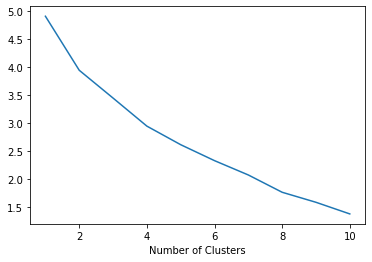

In [74]:
inertia_values = []
k_vals = range(1,11)
for k in k_vals:
    km = KMeans(init='k-means++', n_clusters=k, n_init=12, random_state=0)
    km.fit(cluster_df)
    inertia_values.append(km.inertia_)
plt.plot(k_vals,inertia_values)
plt.xlabel('Number of Clusters')
plt.show()

It's hard to tell where the elbow is. I'll try creating and plotting 4 clusters, and see how that turns out.

In [78]:
# run clustering again with 4 clusters
km = KMeans(init='k-means++', n_clusters=4, random_state=0).fit(cluster_df)

# add the labels to the dataframe with the top 10 venues
neighborhoods_venues_sorted.insert(0, 'Cluster', km.labels_)

# join this dataframe with the toronto neighborhood dataframe
toronto_merge = toronto_df
toronto_merge = toronto_merge.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merge.drop(['index','Postal Code'], axis=1, inplace=True)
toronto_merge.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,"Regent Park, Harbourfront",43.650964,-79.353041,3,Pub,Café,Trail,Athletics & Sports,Mediterranean Restaurant,Theater,Coffee Shop,Distribution Center,French Restaurant,Bank
1,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.661790,-79.389390,3,Coffee Shop,Café,Sushi Restaurant,Yoga Studio,Discount Store,Sandwich Place,Pharmacy,Park,Middle Eastern Restaurant,Italian Restaurant
2,Downtown Toronto,"Garden District, Ryerson",43.657491,-79.377529,3,Coffee Shop,Clothing Store,Sandwich Place,Middle Eastern Restaurant,Italian Restaurant,Cosmetics Shop,Bar,Café,Hotel,Theater
3,Downtown Toronto,St. James Town,43.651734,-79.375554,3,Coffee Shop,Café,Cocktail Bar,American Restaurant,Cosmetics Shop,Gastropub,Seafood Restaurant,Italian Restaurant,Department Store,Creperie
4,East Toronto,The Beaches,43.678148,-79.295349,3,Health Food Store,Pub,Trail,Coffee Shop,Neighborhood,Dog Run,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm


The dataframe looks good, so it's time to plot the neighborhoods again. This time, the color of each dot will correspond with a unique cluster.

In [89]:
# set colors
colors_array = plt.cm.brg(np.linspace(0, 1, len(set(km.labels_))))
colors_list = [colors.rgb2hex(i) for i in colors_array]

# create map
cluster_map = folium.Map(location=coords, zoom_start=12)

# add markers
for lat,lng,hood,cluster in zip(toronto_merge['Latitude'], toronto_merge['Longitude'], toronto_merge['Neighborhood'], toronto_merge['Cluster']):
    label = folium.Popup(str(hood) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=5,
        popup=label,
        color=colors_list[cluster-1],
        fill=True,
        fill_color=colors_list[cluster-1],
        fill_opacity=0.5,
        parse_html=False).add_to(cluster_map)
    
cluster_map

It looks like there's a trend in the clusters around centralized and coastal areas. Let's explore the most common venues in each cluster to look for trends. First I'll define a function to describe a cluster, then I'll loop through each cluster.

In [113]:
def explore_cluster(cluster):
    temp = toronto_merge.loc[toronto_merge['Cluster']==cluster, toronto_merge.columns[list(range(5,toronto_merge.shape[1]))]]
    print('---------------Cluster {}--------------'.format(cluster))
    print(temp.describe())

In [114]:
for c in set(km.labels_):
    explore_cluster(c)

---------------Cluster 0--------------
       1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
count                      7                     7                     7   
unique                     6                     7                     5   
top               Playground              Gym Pool                  Park   
freq                       2                     1                     3   

       4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
count                      7                     7                     7   
unique                     7                     7                     6   
top               Playground        Discount Store                  Park   
freq                       1                     1                     2   

       7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
count                      7                     7                     7   
unique                     6                   

## Results
* The first cluster seems to be defined by outdoor areas like parks and playgrounds.
* The second and third cluster each contain one neighborhood, which appear to be very similar. I'm surprised they ended up in different clusters.
* The fourth cluster seems to be defined by coffee shops, cafes and restaurants.

When I first inspected the K-Means inertia plot, it looked like the elbow indicated 2 clusters. After viewing these results, I understand why.
I believe this analysis is sufficient for the purposes of the assignment, so I will end here.
If I were to continue, I would pursue two directions. First, I'd broaden the analysis to include all neighborhoods, not just those in boroughs with Toronto in the name. I'm curious if outlying areas would continue to cluster together, as they have in my analysis. Second, I'd narrow my focus and repeat the clustering process using only the neighborhoods in the fourth cluster. I'm curious if clusters would become more nuanced, and not be so focused on coffee shops.

## Thank you for reviewing my notebook!